
[Scanpy Clustering Tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)

Get Data:

```
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write 
```

32k genes, 2700 Samples. matrix.mtx sparse integer matrix.

In [11]:
import numpy as np
import pandas as pd
import scanpy as sc

In [12]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.7.0 anndata==0.7.5 umap==0.5.1 numpy==1.19.5 scipy==1.6.0 pandas==1.2.0 scikit-learn==0.24.1 statsmodels==0.12.2


Note I am missing some stuff found in the tutorial:

umap==0.4.2 python-igraph==0.7.1 leidenalg==0.7.0

In [13]:
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results


In [30]:
import anndata
import scipy.io
from pathlib import Path
DATA=Path("data/filtered_gene_bc_matrices/hg19")
a_data = anndata.AnnData(
    X=scipy.io.mmread(DATA/"matrix.mtx").T, 
    obs=pd.read_csv(DATA/"barcodes.tsv", sep = '\t', header=None), 
    var=pd.read_csv(DATA/"genes.tsv", sep = '\t', header=None, index_col=1, names=['gene_ids'])
)
# help(sc.read_10x_mtx)
a2_data = sc.read_10x_mtx(DATA, var_names='gene_symbols',cache=True)
assert (a2_data.X - a_data.X).sum() == 0

a_data.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
a2_data.var_names_make_unique()
assert set(list(a_data.var.index))==set(list(a2_data.var.index))

/Users/jsteill/bin/Virt_Py_Envs/jlab2/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


normalizing counts per cell
    finished (0:00:00)


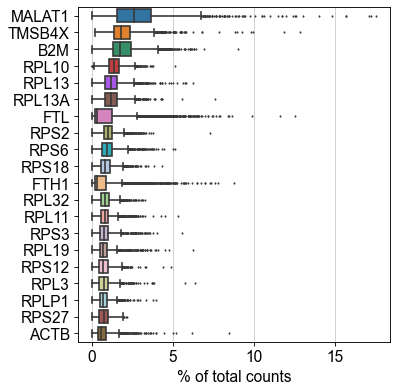

In [31]:
sc.pl.highest_expr_genes(a2_data, n_top=20, )

In [32]:
# Filter out samples which express less than 200 genes, and genes expressed in fewer than 3 cells.
print(a2_data.shape)
sc.pp.filter_cells(a2_data, min_genes=200)
sc.pp.filter_genes(a2_data, min_cells=3)
print(a2_data.shape)

filtered out 19024 genes that are detected in less than 3 cells


(2700, 32738)
(2700, 13714)


In [34]:
#Let’s assemble some information about mitochondrial genes, which are important for quality control.

#Citing from “Simple Single Cell” workflows (Lun, McCarthy & Marioni, 2017):

#High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.
#With pp.calculate_qc_metrics, we can compute many metrics very efficiently.

# Annotate the mitochrondrial genes with a boolean in var.mt
a2_data.var['mt_me'] = list(map(lambda x:x.startswith('MT-'), a2_data.var.index))
a2_data.var['mt'] = a2_data.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
#print(list(map(lambda x:x.startswith('MT-'), a2_data.var.index)))
assert (a2_data.var['mt_me'] == a2_data.var['mt']).all()


# https://scanpy.readthedocs.io/en/stable/api/scanpy.pp.calculate_qc_metrics.html

sc.pp.calculate_qc_metrics(a2_data, qc_vars = ['mt'], percent_top=None, log1p=False, inplace=True)


                  n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
AAACATACAACCAC-1      781                779        2419.0             73.0   
AAACATTGAGCTAC-1     1352               1352        4903.0            186.0   
AAACATTGATCAGC-1     1131               1129        3147.0             28.0   
AAACCGTGCTTCCG-1      960                960        2639.0             46.0   
AAACCGTGTATGCG-1      522                521         980.0             12.0   
...                   ...                ...           ...              ...   
TTTCGAACTCTCAT-1     1155               1153        3459.0             73.0   
TTTCTACTGAGGCA-1     1227               1224        3443.0             32.0   
TTTCTACTTCCTCG-1      622                622        1684.0             37.0   
TTTGCATGAGAGGC-1      454                452        1022.0             21.0   
TTTGCATGCCTCAC-1      724                723        1984.0             16.0   

                  pct_counts_mt  
AAACATACAACCAC-1 

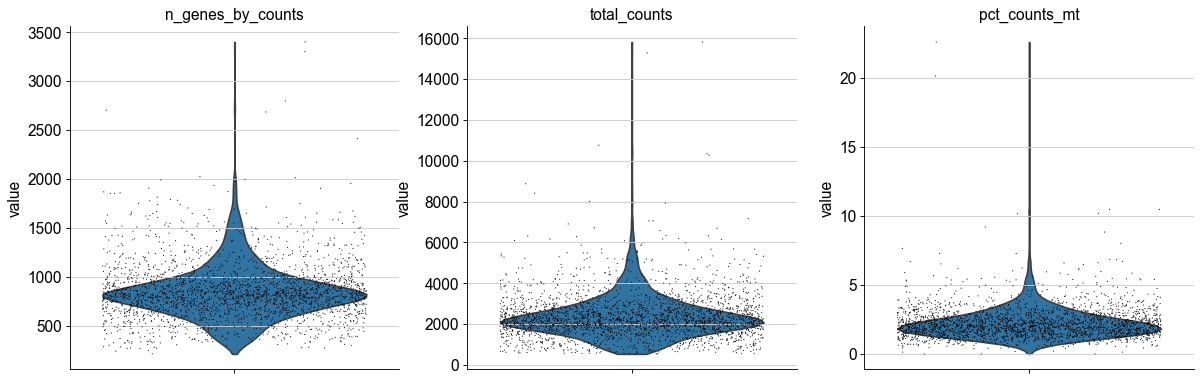

In [28]:
sc.pl.violin(a2_data, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)


In [10]:
# x axis is cell-ordered, not significant.
# n_genes_by_counts - number of genes in a cell with at least one count. ??

a2_data.obs.describe()





,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
count,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000
mean,846.994074,845.546667,2365.376953,50.806667,2.216642
std,282.104964,281.347923,1093.378784,30.891550,1.166708
min,212.000000,212.000000,546.000000,0.000000,0.000000
25%,690.000000,690.000000,1755.750000,31.000000,1.537264
50%,817.000000,816.000000,2196.000000,44.000000,2.030800
75%,953.250000,952.000000,2762.250000,62.000000,2.643177
max,3422.000000,3400.000000,15818.000000,347.000000,22.569027


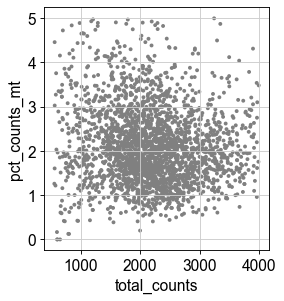

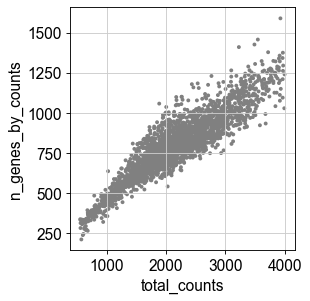

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
count,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000
mean,803.668699,802.361382,2186.728516,45.379269,2.104817
std,197.946513,197.659242,699.166748,22.455297,0.850138
min,212.000000,212.000000,556.000000,0.000000,0.000000
25%,686.750000,686.000000,1745.000000,30.000000,1.508604
50%,807.000000,805.000000,2160.000000,42.000000,1.982727
75%,923.000000,922.000000,2625.000000,57.000000,2.577741
max,1597.000000,1589.000000,3994.000000,168.000000,4.993834


In [54]:
# Remove cells that have too many mitochondrial genes expressed or too many total counts:
adata = a2_data[a2_data.obs.pct_counts_mt < 5.0, :]
adata = adata[adata.obs.total_counts < 4000, :]
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
adata.obs.describe()

In [ ]:
# Total-count normalize (library-size correct) the data matrix 𝐗 to 10,000 reads per cell, so that counts become comparable among cells.